## VGG16 transfer learning with TensorFlow 2
### Binary image classification

In [1]:
from scipy.linalg import toeplitz
import pandas as pd
import numpy as np
import joblib
import datetime
from sklearn import metrics
import os

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

from IPython.display import display, Math
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# From terminal:
# Check current folder is right if using relative log path.
# Manually launch TensorBoard with: tensorboard --logdir=./logs  --port=6006

In [25]:
#!pip freeze > requirements.txt

In [4]:
#Print selected library versions
print('tensorflow:', tf.__version__)
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('joblib:', joblib.__version__)

tensorflow: 2.10.0
pandas: 1.5.0
numpy: 1.23.3
joblib: 1.2.0


### Load dataframe from disk

In [5]:
df = joblib.load('signals.joblib')
df.tail(3)

,nc1,lc1,dc1
799998,0.653171,-0.637368,0.240326
799999,0.047256,0.204431,0.319485
800000,-0.682212,0.365421,0.589967


In [6]:
df.describe().round(2)

,nc1,lc1,dc1
count,800001.00,800001.00,800001.00
mean,0.00,-0.00,-0.00
std,0.61,0.65,0.78
min,-2.83,-5.93,-29.33
25%,-0.48,-0.47,-0.49
50%,0.07,0.06,0.03
75%,0.51,0.50,0.50
max,2.69,6.18,26.15


### Helper Functions

In [7]:
def kernel_density(x, dist_samples=500):    
    '''Univariate KDE of x with scotts_factor for bandwidth.  Returns
    PDF for the specified number of samples in the range of x.'''
    
    from sklearn.neighbors import KernelDensity
    b_width = len(x)**(-1/5)
    x_grid = np.linspace(x.min(), x.max(), dist_samples)    
    kde_model = KernelDensity(bandwidth=b_width)
    kde_model.fit(x[:, np.newaxis])
    y_kde = np.exp(kde_model.score_samples(x_grid[:, np.newaxis]))
    return x_grid, y_kde

In [8]:
def get_signal_window(feature_ser: pd.Series, num_points: int, start_index: int):
    '''Input is signal.  Returns signal segment as 1-D np.array.  Also returns start
    and end indices.'''
    end_index = start_index + num_points
    return feature_ser.iloc[start_index : end_index].values, start_index, end_index

In [9]:
def plot_time_signal(signal: np.array, Hz: float, title: str):
    '''Plot signal.'''
    seconds = np.linspace(start=0.0, stop=len(signal)/Hz, num=len(signal)) # seconds = len(signal)/Hz
    fig, (ax1) = plt.subplots(1,1, figsize=(16,4))
    ax1.plot(seconds, signal, c='black', linewidth=0.5, marker = '.') 
    plt.grid( axis='y')
    ax1.set_title(f'{title} signal - {len(signal)} points over {np.round(len(seconds)/Hz,2)} sec', fontsize=16); 
    ax1.set_xlabel('seconds', fontsize=14); 
    ax1.set_ylabel('amplitude', fontsize=14); 
    ax1.set_xlim(xmin=0);ax1.set_ylim(-2,2)       
    plt.show() 

### Visualize

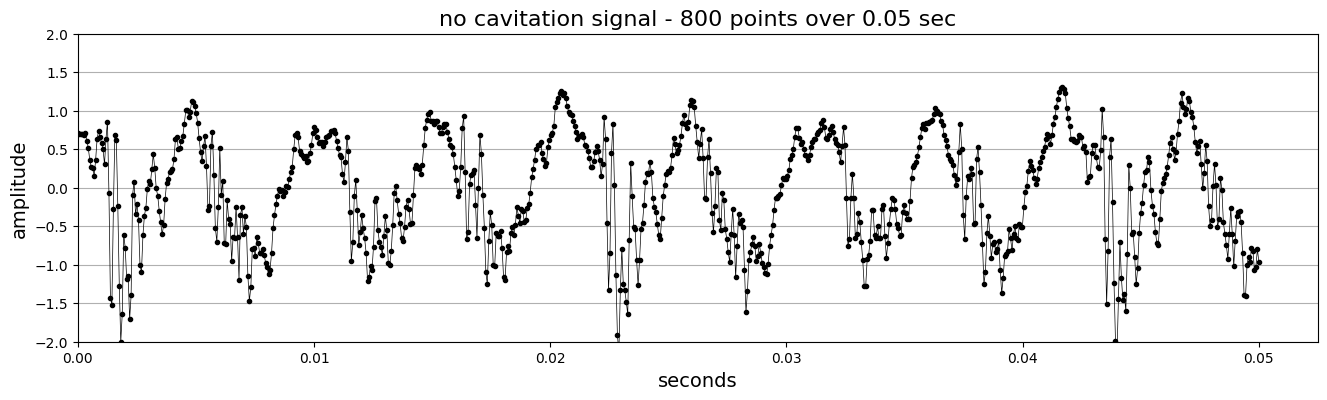

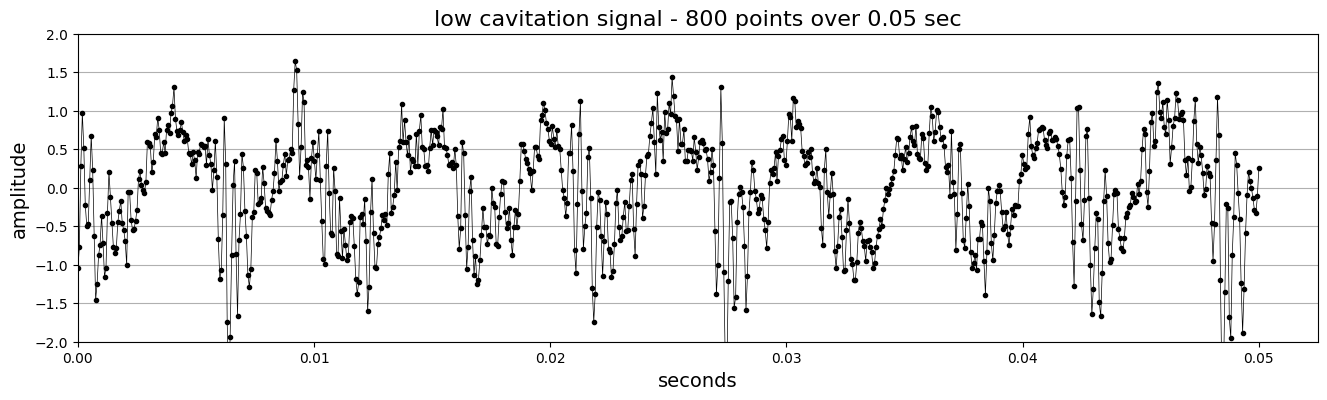

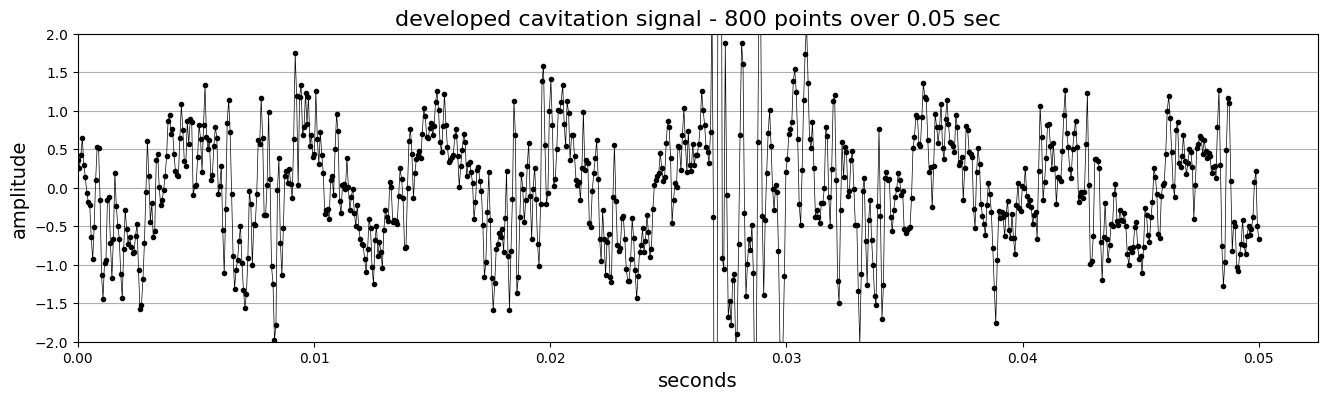

In [10]:
start_idx = 300_000
data_points = 800

sig1, start_idx, end_idx = get_signal_window(feature_ser=df['nc1'], num_points=data_points, start_index=start_idx) 
plot_time_signal(signal=sig1, Hz=16_000, title='no cavitation')
sig1, start_idx, end_idx = get_signal_window(feature_ser=df['lc1'], num_points=data_points, start_index=start_idx) 
plot_time_signal(signal=sig1, Hz=16_000, title='low cavitation')
sig1, start_idx, end_idx = get_signal_window(feature_ser=df['dc1'], num_points=data_points, start_index=start_idx) 
plot_time_signal(signal=sig1, Hz=16_000, title='developed cavitation')

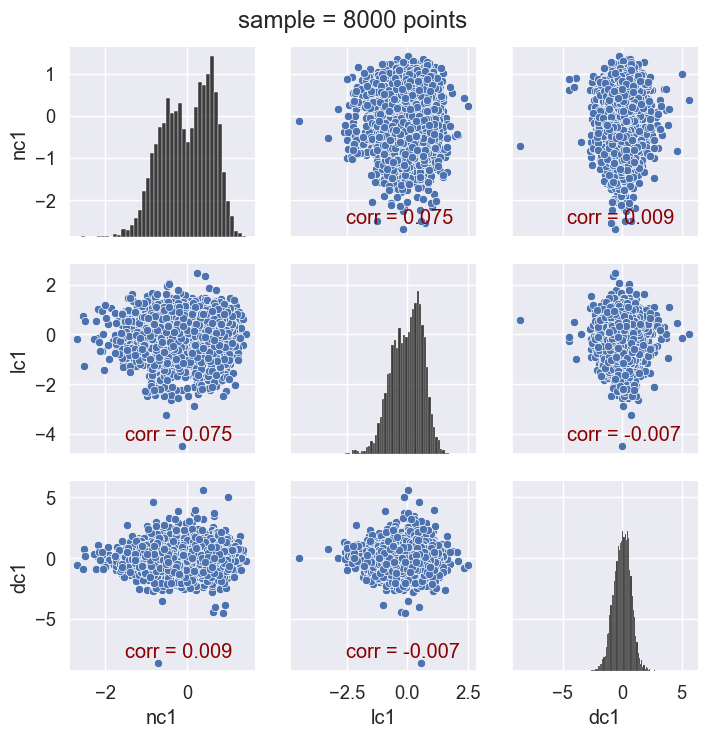

In [11]:
samp = df.sample(frac=0.01, replace=False)   
samp.shape

def annotate_w_xy_corr(x, y, **kwargs):
    coef = np.corrcoef(x, y)[0][1]
    label = r'corr = ' + str(round(coef,3))
    ax = plt.gca()
    ax.annotate(label, xy = (0.3, .07), xycoords = ax.transAxes, c='darkred') #size = 18

def pairplot_w_corr(df : pd.DataFrame):        
        
    sns.set(font_scale=1.2)
    g = sns.PairGrid(df)
    g.fig.subplots_adjust(top=0.93)
    g.fig.suptitle(f'sample = {len(df)} points')
    g.map_upper(sns.scatterplot)
    g.map_upper(annotate_w_xy_corr)
    g.map_lower(sns.scatterplot)
    g.map_lower(annotate_w_xy_corr)
    g.map_diag(sns.histplot, color='black')
    
pairplot_w_corr(df=samp)

# Model with Tensorflow 2

Found 210 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


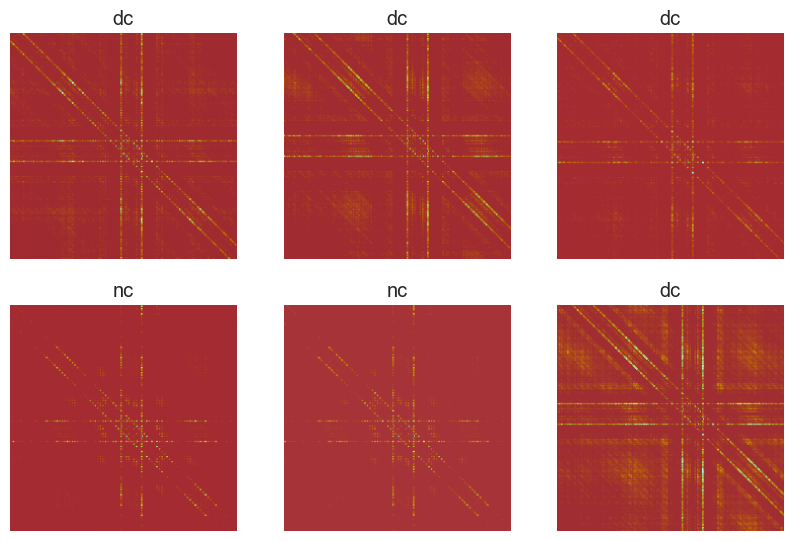

In [12]:
from keras.applications.vgg16 import VGG16

#Create dataset.  The file_paths method shows train_ds and val_ds are mutually exclusive.
train_ds = tf.keras.utils.image_dataset_from_directory(
  './images/train/',
  labels='inferred',
  shuffle=True,
  seed=8,
  image_size=(224, 224),
  batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
  './images/valid/',
  labels='inferred',
  shuffle=True,
  seed=8,
  image_size=(224, 224),
  batch_size=32)

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  #uint is 0 to 255.
        plt.title(class_names[labels[i]]); plt.axis("off");

In [13]:
#Class names and shapes
print('1 train class names:', train_ds.class_names)
print('2 val class names:', val_ds.class_names)

for image_batch, labels_batch in train_ds:
    print('3 images, xpixels, ypixels, color_channels:',image_batch.shape)
    print('4 labels:', labels_batch.shape)
    break

1 train class names: ['dc', 'nc']
2 val class names: ['dc', 'nc']
3 images, xpixels, ypixels, color_channels: (32, 224, 224, 3)
4 labels: (32,)


## Create model

In [14]:
# Load and freeze VGG16 model.
# Include_top=False removes classification layer trained on ImageNet.
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
#Add classification layers.
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(10, activation='relu')
dropout_1 = layers.Dropout(rate=0.3)
prediction_layer = layers.Dense(1, activation='sigmoid') #sigmoid for binary activation

#Transfer learning - base_model plus classifcation layers.
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_1,
    prediction_layer,
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 10)                250890    
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 14,965,589
Trainable params: 250,901
Non-trainable params: 14,714,688
_________________________________________________________________


### Train and Measure

In [16]:
#Train model and get metrics. 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],    
)

from keras.callbacks import Callback

class Histories(Callback):
    
    def on_train_begin(self,logs={}):
        self.batch_loss = []
        self.batch_accuracy = []
        self.loss = []
        self.accuracy = []
        self.val_loss = []
        self.val_accuracy = []
    
    def on_train_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss',-1))
        self.batch_accuracy.append(logs.get('accuracy',-1))               
        
    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss',-1))
        self.accuracy.append(logs.get('accuracy',-1))
        self.val_loss.append(logs.get('val_loss',-1))
        self.val_accuracy.append(logs.get('val_accuracy',-1))

h_cb = Histories()

#Fit model in 3 epochs.  Save metrics to history.
history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[h_cb])

Epoch 1/3
7/7 [==============================] - 14s 1s/step - loss: 1.4756 - accuracy: 0.8286 - val_loss: 6.0902e-09 - val_accuracy: 1.0000
Epoch 2/3
7/7 [==============================] - 1s 119ms/step - loss: 0.1786 - accuracy: 0.9619 - val_loss: 2.3661e-10 - val_accuracy: 1.0000
Epoch 3/3
7/7 [==============================] - 1s 120ms/step - loss: 0.0987 - accuracy: 0.9810 - val_loss: 3.1122e-10 - val_accuracy: 1.0000


### Loss and Accuracy

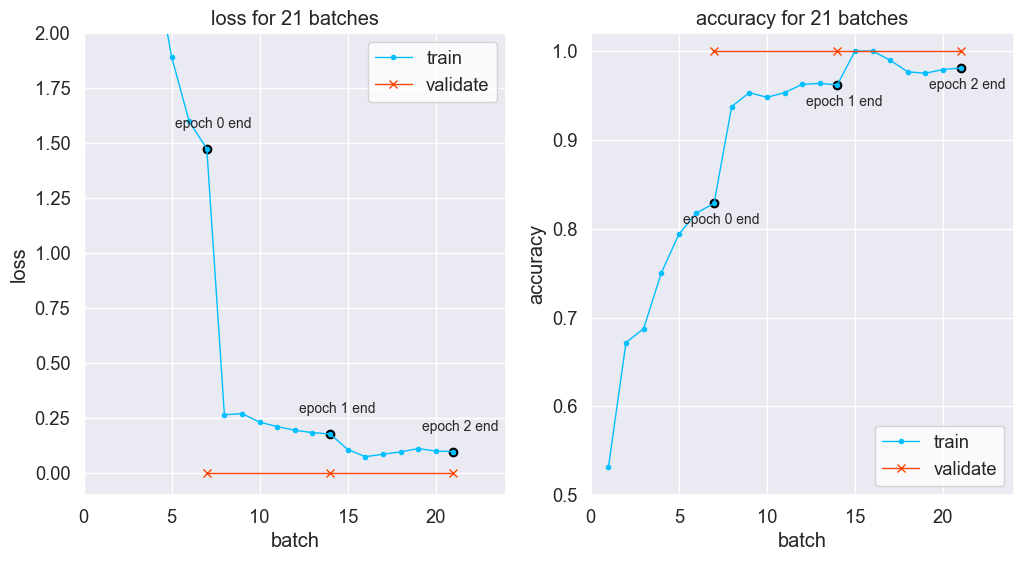

In [17]:
#Accuracy by batch and epoch
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.set_style("whitegrid")
cnt_allbatches = len(h_cb.batch_accuracy)
cnt_allepochs = len(h_cb.accuracy)
batch_x = range(1, len(h_cb.batch_accuracy)+1)
batch_acc = h_cb.batch_accuracy
batch_loss = h_cb.batch_loss

epoch_x = range(cnt_allbatches//cnt_allepochs, cnt_allbatches + 1, cnt_allbatches//cnt_allepochs)
epoch_acc = h_cb.accuracy
epoch_loss = h_cb.loss
val_acc = h_cb.val_accuracy
val_loss = h_cb.val_loss

ax1.plot(batch_x, batch_loss, c='deepskyblue', linewidth=1, marker='.')
ax1.plot(epoch_x, val_loss, c='orangered', linewidth=1, marker='x')
ax1.scatter(epoch_x, epoch_loss, c='black', marker='o')

ax1.set_title(f'loss for {len(batch_loss)} batches');
ax1.set_xlabel('batch'); ax1.set_ylabel('loss') 
ax1.set_xlim(0, len(batch_x)+3)
ax1.set_ylim(-0.1, 2)
ax1.legend(['train','validate'])

for a, b in zip(epoch_x, epoch_loss):
    ax1.annotate(f'epoch {a//9} end', # this is the text
                 (a, b), # these are the coordinates to position the label
                 textcoords='offset points',
                 xytext=(5,15),
                 size = 10,
                 ha='center') # horizontal alignment can be left, right or center

ax2.plot(batch_x, batch_acc, c='deepskyblue', linewidth=1, marker='.')
ax2.plot(epoch_x, val_acc, c='orangered', linewidth=1, marker='x')

ax2.scatter(epoch_x, epoch_acc, c='black', marker='o')
ax2.set_title(f'accuracy for {len(batch_acc)} batches');
ax2.set_xlabel('batch'); ax2.set_ylabel('accuracy') 
ax2.set_xlim(0, len(batch_x)+3)
ax2.set_ylim(0.5, 1.02)
ax2.legend(['train','validate'])

for a, b in zip(epoch_x, epoch_acc):
    ax2.annotate(f'epoch {a//9} end', # this is the text
                 (a, b), # these are the coordinates to position the label
                 textcoords='offset points',
                 xytext=(5,-15),
                 size = 10,
                 ha='center') # horizontal alignment can be left, right or center    

## Why is my training loss much higher than my testing loss?
https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

In [18]:
#Load test dataset for evaluation.
test_ds = tf.keras.utils.image_dataset_from_directory(
  './images/test',
  labels='inferred',
  seed=None,
  image_size=(224, 224),
  batch_size=32)

model.evaluate(test_ds)

Found 120 files belonging to 2 classes.
4/4 [==============================] - 4s 1s/step - loss: 2.4552e-09 - accuracy: 1.0000


[2.4552322397397575e-09, 1.0]

In [19]:
def get_images_and_labels(dataset):    
    tensors = []
    labels = []
    for tensor, label in dataset.take(-1):
        tensors.append(tensor)
        labels.append(label)
    images = np.concatenate(tensors, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

In [20]:
#Get test_ds labels and predictions.
test_im, test_y_true = get_images_and_labels(test_ds)
test_y_pred = np.reshape(model.predict(test_im),-1)
test_y_pred = tf.where(test_y_pred < 0.5,0, 1).numpy()

4/4 [==============================] - 0s 87ms/step


In [21]:
#Classification report
print(metrics.classification_report(y_true=test_y_true, y_pred=test_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



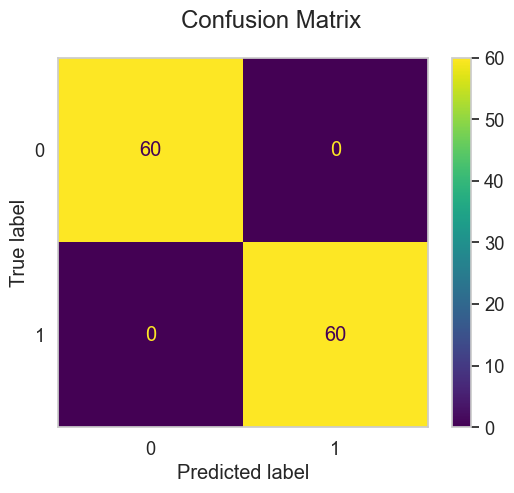

In [22]:
#Confusion matrix
matr = metrics.ConfusionMatrixDisplay.from_predictions(y_true=test_y_true, y_pred=test_y_pred)
matr.figure_.suptitle("Confusion Matrix")
plt.grid(False)

### Quick Peak Counting Example

In [23]:
#Initialize variables.
num_pts = 8000
step_size = 8000  #try step_size 1000 to test 800 segments per feature.
features = ['nc1', 'dc1']
start_idx_grid = range(0, (len(df) - num_pts + 1), step_size)
nc1_error_cnt=0
dc1_error_cnt=0

#Iterate through segments of features.  Segments have num_pts.
for start_idx in start_idx_grid:
    for feat in features:
        end_idx = start_idx + num_pts    
        segment = df[feat].iloc[start_idx:end_idx].values
        x, y_kde = kernel_density(segment, dist_samples=200)
        peaks_num = len(find_peaks(y_kde, height=0.2, distance=None)[0])
        if feat == 'nc1' and peaks_num != 2:
            print(f'Error detail: {feat} indices {start_idx}-{end_idx} | peaks_num:', peaks_num)
            nc1_error_cnt+=1
        if feat == 'dc1' and peaks_num != 1:
            print(f'Error detail: {feat} indices {start_idx}-{end_idx} | peaks_num:', peaks_num)
            dc1_error_cnt+=1

#Summary of errors.
accuracy = round(((len(df)/step_size*2) - (nc1_error_cnt+dc1_error_cnt))/(len(df)/step_size*2)*100,3)
print(f'\n\nTOTAL ERRORS PER FEATURE (step size={step_size}):')
print('--------------------------------------------')
print('nc1 - peaks not equal to 2:', nc1_error_cnt)
print('dc1 - peaks not equal to 1:', dc1_error_cnt,'\n')
print('Overall accuracy:', accuracy, 'percent')

Error detail: nc1 indices 200000-208000 | peaks_num: 1


TOTAL ERRORS PER FEATURE (step size=8000):
--------------------------------------------
nc1 - peaks not equal to 2: 1
dc1 - peaks not equal to 1: 0 

Overall accuracy: 99.5 percent


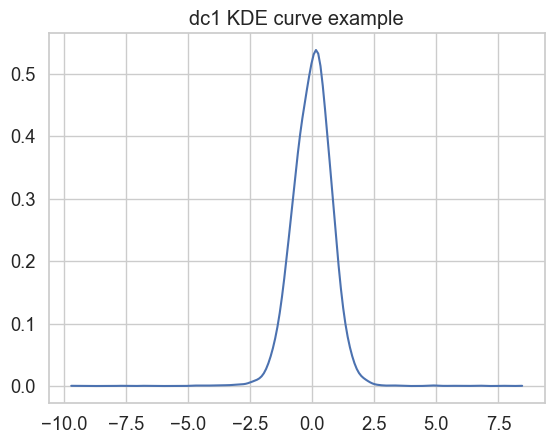

In [24]:
#Show last KDE curve.
plt.plot(x, y_kde)
plt.title(f'{feat} KDE curve example')
plt.show()